In [1]:
import gym
from gym import spaces
import or_gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from or_gym.utils.env_config import *
%matplotlib inline

In [52]:
class POEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        self.num_assets = 1
        self.initial_cash = 100
        self.cash = copy.copy(self.initial_cash)
        self.buy_cost = np.array([0.045, 0.025, 0.035])
        self.sell_cost = np.array([0.04, 0.02, 0.03])
        self.step_limit = 10
        self.asset_price_means = np.ones(self.num_assets) * 10
        self.asset_price_var = np.ones(self.num_assets) * 0.25
        assign_env_config(self, kwargs)
        self.reset()
        # Cash on hand, asset prices, num of shares, portfolio value
        self.obs_length = 1 + 2 * self.num_assets
        self.observation_space = spaces.Box(-0.001, 10000, shape=(self.obs_length,))
        self.action_space = spaces.Box(-1, 1, shape=(self.num_assets,))
        
    def reset(self):
        self.step_count = 0
        self.asset_prices = self._generate_asset_prices()        
        self.holdings = np.zeros(self.num_assets)
        self.cash = copy.copy(self.initial_cash)
        self.last_portfolio_value = copy.copy(self.initial_cash)
        self.state = np.hstack([
            self.initial_cash,
            self.asset_prices[self.step_count],
            self.holdings])
        return self.state
    
    def _generate_asset_prices(self):
        asset_prices = np.vstack([
            np.random.normal(mu, sig, self.step_limit) 
            for mu, sig in zip(self.asset_price_means, self.asset_price_var)])
        # Zero out negative asset prices and all following prices - implies
        # equity is bankrupt and worthless.
        zero_vals = np.vstack(np.where(asset_prices<0))
        cols = np.unique(zero_vals[0])
        for c in cols:
            first_zero = zero_vals[1][np.where(zero_vals[0]==c)[0].min()]
            asset_prices[c,first_zero:] = 0
        return asset_prices.T.round(3)
    
    def step(self, action):
        assert self.action_space.contains(action)
        # Normalize actions to sum to 1
        if sum(action) > 1:
            action = action / action.sum()
        asset_prices = self.asset_prices[self.step_count].copy()
        portfolio_value = np.dot(asset_prices, self.holdings) + self.cash
        for idx, a in enumerate(action):
#             if asset_prices[idx] == 0:
#                 # Asset is worthless
                
            if a == 0:
                continue
            # Sell a shares of asset
            elif a < 0:
                shares_to_sell = np.floor(asset_prices[idx] / 
                    np.abs(a) * portfolio_value)
                if shares_to_sell > self.holdings[idx]:
                    shares_to_sell = self.holdings[idx].copy()
                price = asset_prices[idx] * shares_to_sell * (1 - self.sell_cost[idx])
                self.cash += asset_prices[idx] * shares_to_sell * (1 - self.sell_cost[idx])
                self.holdings[idx] -= shares_to_sell
                
            # Buy a shares of asset
            elif a > 0:
                shares_to_buy = np.ceil(a * portfolio_value * (1 - self.buy_cost[idx])/ asset_prices[idx])
                purchase_cost = asset_prices[idx] * shares_to_buy * (1 + self.buy_cost[idx])
                if self.cash < purchase_cost:
                    shares_to_buy = np.floor(self.cash * (1 - self.buy_cost[idx]) /
                                             asset_prices[idx])
                    purchase_cost = asset_prices[idx] * shares_to_buy * (1 + self.buy_cost[idx])
                self.holdings[idx] += shares_to_buy
                self.cash -= purchase_cost
                
        # Return total portfolio value as reward
        portfolio_value = np.dot(asset_prices, self.holdings) + self.cash
#         reward = portfolio_value - self.last_portfolio_value
        self.last_portfolio_value = copy.copy(portfolio_value)
        reward = portfolio_value / self.initial_cash - 1
        self.step_count += 1
        if self.step_count >= self.step_limit:
            done = True
        else:
            self._update_state()
            done = False
            
        return self.state, reward, done, {}
    
    def _update_state(self):
        self.state = np.hstack([
            self.cash,
            self.asset_prices[self.step_count],
            self.holdings
        ])

In [46]:
env = POEnv()
for i in range(1000):
    s = env.reset()
    done = False
    states, rewards, actions = [], [], []
    t = 0
    while done == False:
        action = env.action_space.sample()
        s, r, done, _ = env.step(action)
        valid_state = env.observation_space.contains(s)
        if not valid_state:
            raise ValueError("Invalid observation state:\n{}".format(s))
        actions.append(action)
        states.append(s)
        rewards.append(r)
        t += 1

In [48]:
import ray
from ray.rllib import agents
from copy import deepcopy
import time
ray.init(ignore_reinit_error=True)

2020-05-15 15:27:45,466	ERROR worker.py:679 -- Calling ray.init() again after it has already been called.


In [49]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent(algo='a3c', iters=50, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, 
            env=POEnv)
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [53]:
config_dict = {'grad_clip': 10}
trainer, results = train_agent(config_dict={})

2020-05-15 15:32:29,718	WARNING util.py:45 -- Install gputil for GPU system monitoring.


{'cur_lr': 9.999999747378752e-05, 'policy_loss': 0.04093497, 'policy_entropy': 12.987276, 'var_gnorm': 22.682053, 'vf_loss': 1.167902e-05, 'model': {}, 'grad_gnorm': 1.5343132, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 1.6747286, 'policy_entropy': 24.031727, 'var_gnorm': 22.783335, 'vf_loss': 0.022417434, 'model': {}, 'grad_gnorm': 9.97196, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 0.41952375, 'policy_entropy': 28.320234, 'var_gnorm': 22.843681, 'vf_loss': 5.8162586e-05, 'model': {}, 'grad_gnorm': 0.74181724, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 1.6456466, 'policy_entropy': 29.608612, 'var_gnorm': 22.890295, 'vf_loss': 0.026507845, 'model': {}, 'grad_gnorm': 7.0262814, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 1.2203407, 'policy_entropy': 33.58836, 'var_gnorm': 22.933289, 'vf_loss': 0.0044461843, 'model': {}, 'grad_gnorm': 3.3783135, 'vf_explained_var

{'cur_lr': 9.999999747378752e-05, 'policy_loss': -0.41961184, 'policy_entropy': 57.106113, 'var_gnorm': 25.761147, 'vf_loss': 3.5894127e-06, 'model': {}, 'grad_gnorm': 1.910241, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 2.5535154, 'policy_entropy': 56.715088, 'var_gnorm': 25.989035, 'vf_loss': 0.0042161234, 'model': {}, 'grad_gnorm': 2.5497973, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 3.944882, 'policy_entropy': 57.40443, 'var_gnorm': 26.114565, 'vf_loss': 0.019727618, 'model': {}, 'grad_gnorm': 6.580287, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 2.692574, 'policy_entropy': 57.87999, 'var_gnorm': 26.258581, 'vf_loss': 0.008699879, 'model': {}, 'grad_gnorm': 3.3465836, 'vf_explained_var': -1.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 1.8134389, 'policy_entropy': 59.340492, 'var_gnorm': 26.388641, 'vf_loss': 0.014967622, 'model': {}, 'grad_gnorm': 6.053084, 'vf_explained_var': -1.

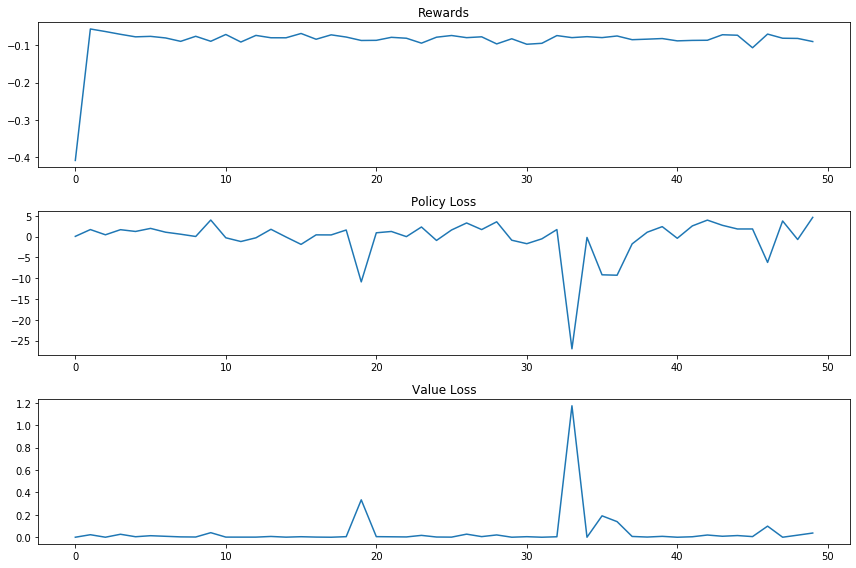

In [54]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]

fig, ax = plt.subplots(3, 1, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Policy Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

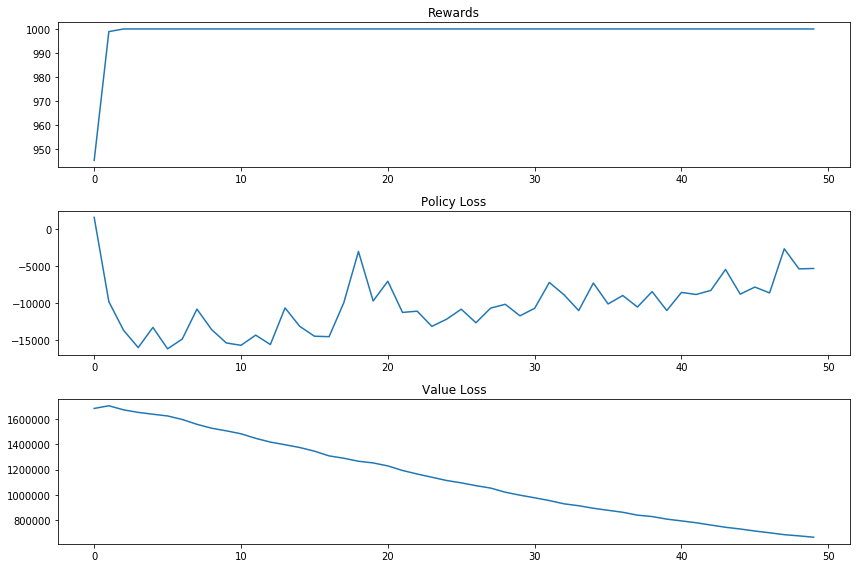

In [51]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]

fig, ax = plt.subplots(3, 1, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Policy Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

# Run trained algorithm

In [63]:
env = POEnv()
s = env.reset()
for i in range(10):
    action = trainer.compute_action(s)
    s, r, done, _ = env.step(action)
    print(action, r)
    if done:
        break

[-1.] 0.0
[-1.] 0.0
[-1.] 0.0
[-1.] 0.0
[1.] -0.04076729999999995
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013


In [26]:
# View configuration defaults
config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'sample_batch_size': 10,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 200,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_preprocessor': None,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {}},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.0001,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_start': None,
  'on_episode_ste